In [1]:
import pandahouse as ph
import numpy as np
import seaborn as sns

import scipy.stats as stats
from tqdm.notebook import tqdm

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'xxx',
    'user': 'xxx',
    'database': 'xxx'
}

In [3]:
query = """
select
  user_id,
  exp_group,
  countIf(user_id, action = 'like') as likes,
  countIf(user_id, action = 'view') as views,
  likes / views as ctr
from
  {db}.feed_actions
where
  toDate(time) between '2023-01-31'
  and '2023-02-06'
  and exp_group in (1, 2)
group by
  exp_group,
  user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head(3)

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575


## Общее

 - В условии задачи сказано, что необходимо сравнить CTR двух групп.
 - Т.е. будет два числа, CTR для первой группы, и CTR для второй.
 - Получается, надо получить распределение CTR для каждой группы, а затем применить метод сравнения.
 - Буду использовать метод сравнения t-test.
 - Распределения буду получать с применением бутстрепа.

In [5]:
# получаем массив значений лайков и просмотров для каждой группы
data_g1 = df[df['exp_group'] == 1][['likes', 'views']].copy().values
data_g2 = df[df['exp_group'] == 2][['likes', 'views']].copy().values

# посмотрим на размеры выборок
size_g1 = data_g1.shape[0]
size_g2 = data_g2.shape[0]

print(f'g1 = {size_g1}\ng2 = {size_g2}')

g1 = 10079
g2 = 9952


In [6]:
# количество повторов возьмем из задания 1
N = 10000

ctr_g1 = []
ctr_g2 = []

# набутстрапируем выборки для CTR
for i in tqdm(range(N)):
    likes_g1, views_g1 = np.sum(data_g1[np.random.choice(a=size_g1, size=size_g1)], axis=0)
    likes_g2, views_g2 = np.sum(data_g2[np.random.choice(a=size_g2, size=size_g2)], axis=0)
    
    ctr_g1.append(likes_g1 / views_g1)
    ctr_g2.append(likes_g2 / views_g2)

  0%|          | 0/10000 [00:00<?, ?it/s]

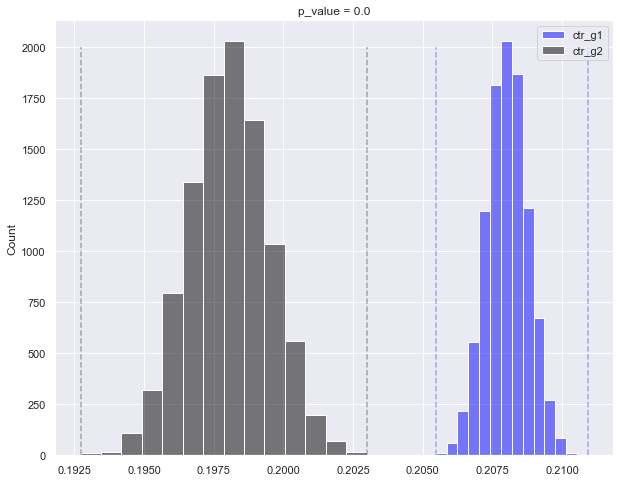

In [10]:
# взглянем на распределения CTR по группам
sns.set_theme(rc={'figure.figsize': (10, 8)})

# посчитаем кол-во интервалов

ax = sns.histplot(data=ctr_g1,
             palette=['r'],
             color='blue',
             alpha=0.5,
             bins=(1 + int(np.log2(len(ctr_g1)))),
             label='ctr_g1');

# границы для 1 группы
ax.vlines(x=[np.min(ctr_g1), np.max(ctr_g1)],
          ymin=0, ymax=2000,
          linestyles='--',
          color='blue',
          alpha=0.3)

sns.histplot(data=ctr_g2,
             ax=ax,
             color='black',
             alpha=0.5,
             bins=(1 + int(np.log2(len(ctr_g2)))),
             label='ctr_g2');

# границы для 2 группы
ax.vlines(x=[np.min(ctr_g2), np.max(ctr_g2)],
          ymin=0, ymax=2000,
          linestyles='--',
          color='black',
          alpha=0.3)

statistic, p_value = stats.ttest_ind(a=ctr_g1, b=ctr_g2, equal_var=False)
ax.set_title(f'p_value = {p_value}')

ax.legend();

### Вывод

Основная гипотеза заключалась в том, что новый алгоритм во 2-ой группе приведет к увеличению CTR.

По результатам анализа оказалось, что новый алгоритм приводит к уменьшению CTR. Выявлена статистическая значимость между группами.

Поскольку CTR это отношение лайков к просмотрам (в данном случае), то скорее всего рекомендовались нерелевантные посты. Пользователи лайкали примерно как и всегда, а вот просмотров стало больше, а лайкать неинтересные посты пользователь не хочет.

Как итог, на данный момент, раскатывать алгоритм на всех пользователей не стоит.

### Вариант второй

Возможно, я не так понял задание и надо было сравнить именно распределения CTR по группам. Т.е. взять CTR для каждого из пользователей в группе и построить распределение.
Сделаем такой вариант.

In [8]:
# получим данные CTR по каждому пользователю для каждой группы
ctr_data_g1 = df[df['exp_group'] == 1]['ctr'].copy().values
ctr_data_g2 = df[df['exp_group'] == 2]['ctr'].copy().values

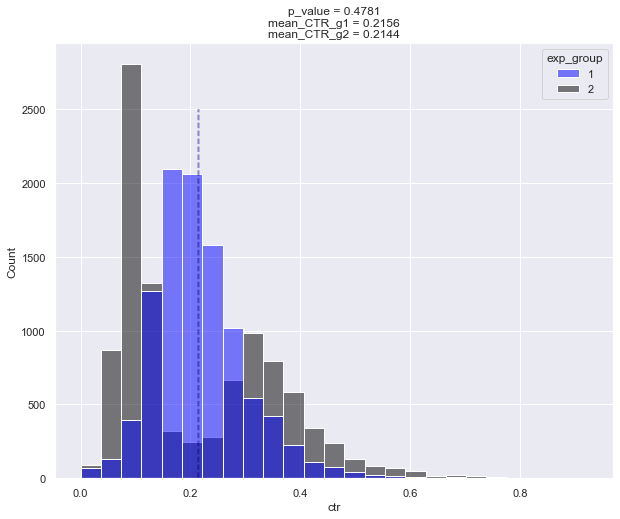

In [11]:
statistica_ctr, p_value_ctr = stats.ttest_ind(a=ctr_data_g1,
                                              b=ctr_data_g2,
                                              equal_var=False)

# среднее CTR в группах
mean_ctr_g1 = np.mean(ctr_data_g1)
mean_ctr_g2 = np.mean(ctr_data_g2)

# кол-во интервалов подберем руками, чтобы увидеть различия в распределениях
ax_ctr = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette=['blue', 'black'],
                      bins=25)
ax_ctr.set_title(f'p_value = {round(p_value_ctr, 4)}\nmean_CTR_g1 = {np.round(mean_ctr_g1, 4)}\
\nmean_CTR_g2 = {round(mean_ctr_g2, 4)}');

# среднее для 1 группы
ax_ctr.vlines(x=mean_ctr_g1,
          ymin=0, ymax=2500,
          linestyles='--',
          color='blue',
          alpha=0.3);

# среднее для 2 группы
ax_ctr.vlines(x=mean_ctr_g2,
          ymin=0, ymax=2500,
          linestyles='--',
          color='black',
          alpha=0.3);

### Вывод

Четко видно, что в группах распределения имеют разные типы. В 1-й группе оно похоже на нормальное, а во 2-ой на бимодальное.

На графике видно как средние значения накладываются друг на друга, + по значениям они практически одинаковы.

При этом, Т-тест не выявил статистической значимости.

Поскольку статистической значимости выявлено не было, то раскатывать новый алгоритм на всех новых пользователей не стоит.

=============

"*Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.*"

Предположу, что справшивают про ситуацию с бимодальным распределением.

Предположу, как и в первом случае (с бутсрепом), что просмотры сильно прыгали. Возможно из-за нерелевантных постов, вследствии чего CTR был не стабилен.